In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers #type:ignore
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [64]:
# Preparing the dataset and creating the features and target arrays

n_sims = 1000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'../input31/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
# y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 1000/1000 [00:00<00:00, 3917.72it/s]


In [99]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    patience=5,          
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001       
)

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=100,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [145]:
# defining the model

model = models.Sequential()

model.add(layers.Flatten())


model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam', metrics=keras.metrics.MeanAbsoluteError())


history = model.fit(x_train, y_train, validation_split=.2, epochs=25, batch_size=8, verbose=1, callbacks=[reduce_lr])

Epoch 1/25
75/75 [==============================] - 1s 6ms/step - loss: 566.8878 - mean_absolute_error: 11.6016 - val_loss: 0.7991 - val_mean_absolute_error: 0.7527 - lr: 0.0010
Epoch 2/25
75/75 [==============================] - 0s 5ms/step - loss: 0.7966 - mean_absolute_error: 0.7630 - val_loss: 0.7576 - val_mean_absolute_error: 0.7400 - lr: 0.0010
Epoch 3/25
75/75 [==============================] - 0s 5ms/step - loss: 0.7849 - mean_absolute_error: 0.7600 - val_loss: 0.7500 - val_mean_absolute_error: 0.7403 - lr: 0.0010
Epoch 4/25
75/75 [==============================] - 0s 5ms/step - loss: 0.7961 - mean_absolute_error: 0.7594 - val_loss: 0.7481 - val_mean_absolute_error: 0.7393 - lr: 0.0010
Epoch 5/25
75/75 [==============================] - 0s 5ms/step - loss: 0.8044 - mean_absolute_error: 0.7643 - val_loss: 0.7718 - val_mean_absolute_error: 0.7458 - lr: 0.0010
Epoch 6/25
75/75 [==============================] - 0s 5ms/step - loss: 0.7967 - mean_absolute_error: 0.7593 - val_loss: 0

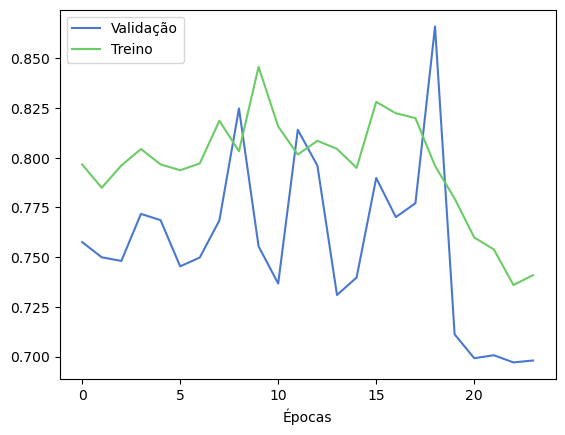

In [146]:
plt.plot(history.history['val_loss'][1:], label='Validação')
plt.plot(history.history['loss'][1:], label='Treino')


plt.xlabel('Épocas')
plt.legend()


# plt.savefig("imagens/loss_h0_dense")

plt.show()

In [147]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

mse

8/8 [==============================] - 0s 1ms/step


0.6370465034252377

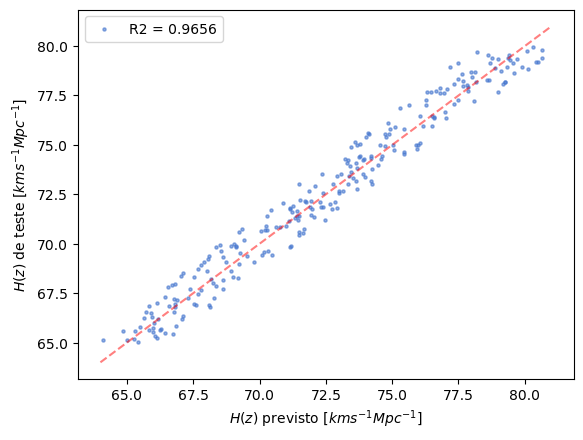

In [148]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.28, .35, 2500)


# plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.scatter(y_pred, y_test, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()


plt.xlabel(r'$H (z)$ previsto [$km s^{-1} Mpc^{-1}$] ')
plt.ylabel(r'$H (z)$ de teste [$km s^{-1} Mpc^{-1}$] ')


# plt.savefig("imagens/metrics_h0_dense")
plt.show()

In [149]:
# forecasting "real" H(0)

real = np.load('../input31/data_real31.npy')
# real = real[real[:, 1].argsort()]

real = real.reshape(-1,31,2)

In [150]:
real[:, :, 0][0]

array([0.07   , 0.09   , 0.12   , 0.17   , 0.1791 , 0.1993 , 0.2    ,
       0.27   , 0.28   , 0.3519 , 0.3802 , 0.4    , 0.4004 , 0.4247 ,
       0.44497, 0.47   , 0.4783 , 0.48   , 0.5929 , 0.6797 , 0.7812 ,
       0.8754 , 0.88   , 0.9    , 1.037  , 1.3    , 1.363  , 1.43   ,
       1.53   , 1.75   , 1.965  ])

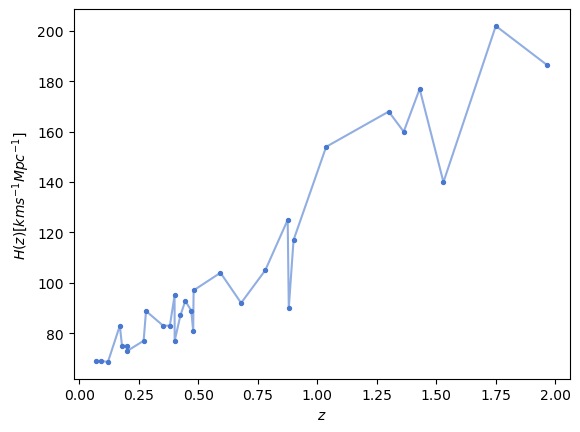

In [151]:

plt.scatter(real[:, :, 0][0], real[:, :, 1][0], s=8)
plt.plot(real[:, :, 0][0], real[:, :, 1][0], alpha=.6)

plt.xlabel(r'$z$')
plt.ylabel(r'$H (z)$[$km s^{-1} Mpc^{-1}$] ')

plt.show()

In [152]:

final_real = model.predict(real, verbose=0)

In [153]:
# final_real*norm
final_real

array([[69.93279]], dtype=float32)

In [154]:
# keras.utils.plot_model(model, to_file='imagens/model_dense.png', show_shapes=False, show_layer_names=False)


In [155]:
# model.save('models/dense')